# Model to Predict pIC50 based on SMILES
Aim: Create machine learning model to predict pIC50 values of SMILES generated by the DrugEx Demo

In [460]:
from pathlib import Path
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [461]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

# Load Data
The data of Lipinski drugs will be used in order to have more data available

In [462]:
data = pd.read_csv(DATA / "PTP1B_compounds_lipinski.csv")

#inactive & active classification
data['active'] = (data['pIC50']>7)
data

,Unnamed: 0.1,Unnamed: 0,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,molecular_weight.1,n_hba.1,n_hbd.1,logp.1,ro5_fulfilled,active
0,14,14,CHEMBL411295,7.0,nM,O=C(O)c1cccc(/C=C/c2ccc3cc(Br)c(C(F)(F)P(=O)(O...,8.154902,482.968278,3,3,5.0929,482.968278,3,3,5.0929,True,True
1,16,16,CHEMBL377141,10.0,nM,O=C1CC(c2ccc(C[C@H](NS(=O)(=O)c3cccc(C(F)(F)F)...,8.000000,652.024097,6,2,2.3154,652.024097,6,2,2.3154,True,True
2,18,18,CHEMBL1938829,11.0,nM,O=C(O)COc1ccc(S(=O)(=O)N(Cc2ccc(-c3csnn3)cc2)C...,7.958607,694.056877,9,3,4.9739,694.056877,9,3,4.9739,True,True
3,22,22,CHEMBL604457,12.6,nM,CS(=O)(=O)OC1C(Cl)CCCC1Cc1ccc(N2CC(=O)CS2(=O)=...,7.899629,451.052622,7,1,1.4059,451.052622,7,1,1.4059,True,True
4,23,23,CHEMBL592290,14.0,nM,O=C1CN(c2c(O)cc(CC3CCCCC3)cc2F)S(=O)(=O)C1,7.853872,341.109707,4,1,2.3730,341.109707,4,1,2.3730,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,2977,2977,CHEMBL99971,12000000.0,nM,O=C(O)c1ccc2c(C(=O)O)c(O)ccc2c1,1.920819,232.037173,3,3,1.9418,232.037173,3,3,1.9418,True,False
1988,2978,2978,CHEMBL324473,12200000.0,nM,C=CCOC(=O)/C=C\c1cccc(C(F)(F)P(=O)(O)O)c1.N.N,1.913640,352.099965,5,4,2.9800,352.099965,5,4,2.9800,True,False
1989,2980,2980,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970,246.052823,3,2,2.2448,246.052823,3,2,2.2448,True,False
1990,2981,2981,CHEMBL95668,28000000.0,nM,O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12.[Na...,1.552842,331.940118,6,0,-5.3440,331.940118,6,0,-5.3440,True,False


## Smiles to Fingerprint

In [463]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

## Splitting Data into Train and Test

In [464]:
X_train, X_test, y_train, y_test = train_test_split(data['smiles'].values, data['active'].values, test_size=0.3)

In [465]:
fp_X_train = []
for i in range(len(X_train)):
    fp_X_train.append(smiles_to_fp(X_train[i]))
    

In [466]:
fp_X_test = []
for i in range(len(X_test)):
    fp_X_test.append(smiles_to_fp(X_test[i]))

In [467]:
fp_X_train = np.array(fp_X_train)
fp_X_test = np.array(fp_X_test)
fp_X_train.shape
y_test.shape

(598,)

## Neural Network

In [509]:
#Build model
inputLayer = Input(167,)
Hidden = Dense(32)(inputLayer)
Hidden = Dense(32, activation='relu')(Hidden)
Output = Dense(1, activation='sigmoid')(Hidden)

In [510]:
Model = tf.keras.Model(inputs=inputLayer, outputs=Output)
Model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 167)]             0         
                                                                 
 dense_88 (Dense)            (None, 32)                5376      
                                                                 
 dense_89 (Dense)            (None, 32)                1056      
                                                                 
 dense_90 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [515]:
Model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['accuracy'])
History = Model.fit(fp_X_train, y_train, validation_split=0.3, epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 11ms/step - loss: 0.0303 - accuracy: 0.9856 - val_loss: 0.2003 - val_accuracy: 0.9618
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0353 - accuracy: 0.9815 - val_loss: 0.2103 - val_accuracy: 0.9642
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0312 - accuracy: 0.9836 - val_loss: 0.2472 - val_accuracy: 0.9642
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0325 - accuracy: 0.9815 - val_loss: 0.2139 - val_accuracy: 0.9690
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0321 - accuracy: 0.9826 - val_loss: 0.1968 - val_accuracy: 0.9618
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0318 - accuracy: 0.9815 - val_loss: 0.2080 - val_accuracy: 0.9618
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0311 - accuracy: 0.9846 - val_loss: 0.2153 - val_accuracy: 0.9666
Epoch 8/100


Epoch 59/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0231 - accuracy: 0.9877 - val_loss: 0.3123 - val_accuracy: 0.9690
Epoch 60/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0201 - accuracy: 0.9918 - val_loss: 0.3024 - val_accuracy: 0.9690
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0187 - accuracy: 0.9918 - val_loss: 0.3010 - val_accuracy: 0.9690
Epoch 62/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0199 - accuracy: 0.9877 - val_loss: 0.3410 - val_accuracy: 0.9690
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0179 - accuracy: 0.9908 - val_loss: 0.3004 - val_accuracy: 0.9714
Epoch 64/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0207 - accuracy: 0.9897 - val_loss: 0.3271 - val_accuracy: 0.9690
Epoch 65/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0256 - accuracy: 0.9846 - val_loss: 0.3503 - val_accuracy: 0.9666
Epoch 

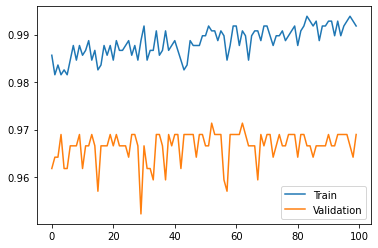

In [516]:
plt.plot(History.history['accuracy'], label='Train')
plt.plot(History.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

## Evaluate performance on train and validation set combined

In [517]:
evaluate = []
for i in range(len(data)):
    evaluate.append(smiles_to_fp(data['smiles'][i]))

evaluate = np.array(evaluate)
Model.evaluate(evaluate,data['active'].values)
    
Preds = Model(evaluate).numpy().round()
print("Predicted amount of active comps:",Model(evaluate).numpy().round().sum())
print("Actual amount of active comps:", data['active'].values.sum())
Preds = Preds.astype(bool)
Pos = data[Preds]
Neg = data[~Preds]



63/63 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.9829
Predicted amount of active comps: 47.0
Actual amount of active comps: 71


In [518]:
print("True Positives: ", Pos['active'].sum())
print("False Positives: ", len(Pos)-Pos['active'].sum())
print("True Negatives: ", len(Neg)-Neg['active'].sum())
print("False Negatives: ", Neg['active'].sum())

True Positives:  42
False Positives:  5
True Negatives:  1916
False Negatives:  29


## Save Model

In [519]:
Model.save(DATA/"Activity_prediction.h5")